# **PERSONALITY PREDICTION**

In [770]:
%cd /content/drive/MyDrive/PRML/Bonus_Project

/content/drive/MyDrive/PRML/Bonus_Project


##Libraries used

In [771]:
import pandas as pd
import numpy as np
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
!pip install contractions
import contractions
import re
from bs4 import BeautifulSoup

import nltk
nltk.download('wordnet')
nltk.download('stopwords')

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score,log_loss
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import make_scorer

from tqdm import tqdm
from sklearn import metrics

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Importing dataset

In [772]:
df = pd.read_csv('mbti_1.csv')
df

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


In [773]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


##Posts written by each personality type

In [774]:
type_sum = df.groupby(['type']).count()
type_sum.sort_values('posts', ascending=False, inplace=True)
type_sum

,posts
type,
INFP,1832
INFJ,1470
INTP,1304
INTJ,1091
ENTP,685
ENFP,675
ISTP,337
ISFP,271
ENTJ,231


##Plotting personality types

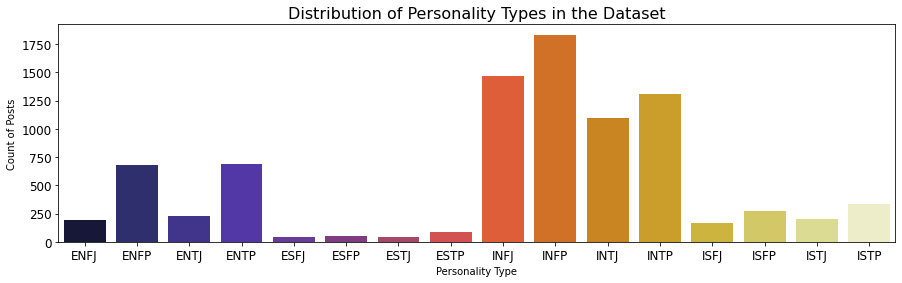

In [775]:
dim = (15.0, 4.0)
fig, ax = plt.subplots(figsize=dim)
cmrmap = sns.color_palette('CMRmap', 16)
sns.set_palette(cmrmap)
sns.countplot(x='type', data=df,
              order=['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ',
                     'ESTP', 'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP',
                     'ISTJ', 'ISTP'])
plt.title('Distribution of Personality Types in the Dataset', fontsize=16)
plt.xlabel('Personality Type')
plt.ylabel('Count of Posts')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

The 'ES' personality types have the least posts, whilst the 'IN' personalities have the most posts. This suggests that the data is imbalanced.

##Create a binary column for each of the 4 dimension types and handling data imbalance

In [776]:
df['Mind'] = df['type'].map(lambda x: 'Extroverted'
                                  if x[0] == 'E' else 'Introverted')
df['Energy'] = df['type'].map(lambda x: 'Intuitive'
                                    if x[1] == 'N' else 'Sensing')
df['Nature'] = df['type'].map(lambda x: 'Thinking'
                                    if x[2] == 'T' else 'Feeling')
df['Tactics'] = df['type'].map(lambda x: 'Judging'
                                     if x[3] == 'J' else 'Perceiving')

###Mind

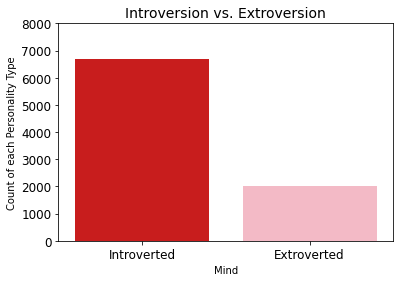

In [777]:
IEcolors = sns.xkcd_palette(['red', 'soft pink'])
sns.set_palette(IEcolors)
sns.countplot(x='Mind', data=df, order=['Introverted', 'Extroverted'])
plt.ylim(0, 8000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Mind')
plt.ylabel('Count of each Personality Type')
plt.title('Introversion vs. Extroversion', fontsize=14)
plt.show()

####Handling data imbalance

In [778]:
df['Mind'].value_counts()

Introverted    6676
Extroverted    1999
Name: Mind, dtype: int64

In [779]:
from sklearn.utils import resample
#create two different dataframe of majority and minority class 
df_majority = df[df['Mind']=='Introverted'] 

df_minority = df[df['Mind']=='Extroverted'] 

# upsample minority class
df = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 6676, # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
df = pd.concat([df, df_majority])

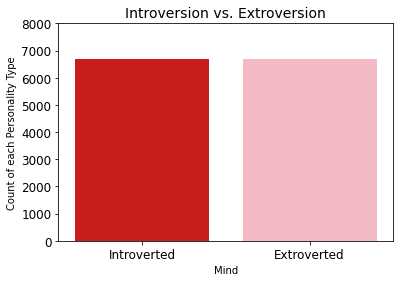

In [780]:
IEcolors = sns.xkcd_palette(['red', 'soft pink'])
sns.set_palette(IEcolors)
sns.countplot(x='Mind', data=df, order=['Introverted', 'Extroverted'])
plt.ylim(0, 8000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Mind')
plt.ylabel('Count of each Personality Type')
plt.title('Introversion vs. Extroversion', fontsize=14)
plt.show()

###Energy

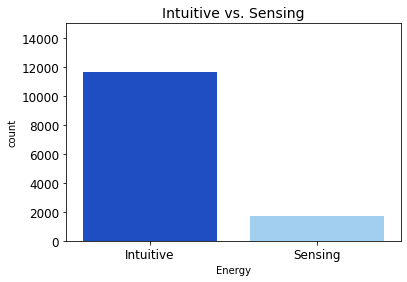

In [781]:
NScolors = sns.xkcd_palette(['blue', 'light blue'])
sns.set_palette(NScolors)
sns.countplot(x='Energy', data=df, order=['Intuitive', 'Sensing'])
plt.title('Intuitive vs. Sensing', fontsize=14)
plt.ylim(0, 15000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

####Handling data imbalance

In [782]:
df['Energy'].value_counts()

Intuitive    11631
Sensing       1721
Name: Energy, dtype: int64

In [783]:
from sklearn.utils import resample
#create two different dataframe of majority and minority class 
df_majority = df[df['Energy']=='Intuitive'] 

df_minority = df[df['Energy']=='Sensing'] 

# upsample minority class
df = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 11631, # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
df = pd.concat([df, df_majority])

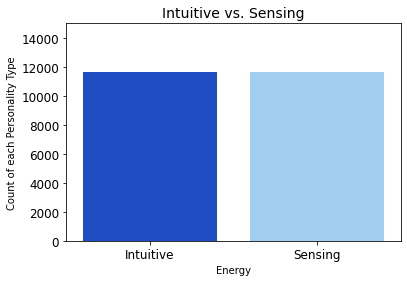

In [784]:
IEcolors = sns.xkcd_palette(['blue', 'light blue'])
sns.set_palette(IEcolors)
sns.countplot(x='Energy', data=df, order=['Intuitive', 'Sensing'])
plt.ylim(0, 15000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Energy')
plt.ylabel('Count of each Personality Type')
plt.title('Intuitive vs. Sensing', fontsize=14)
plt.show()

###Nature

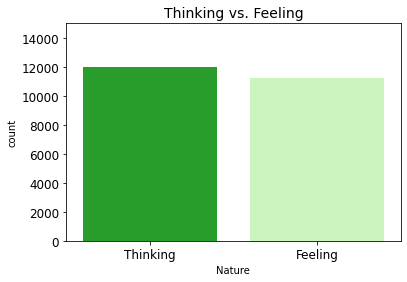

In [785]:
# Countplot of the Tinking - Feeling variable
TFcolors = sns.xkcd_palette(['green', 'pale green'])
sns.set_palette(TFcolors)
sns.countplot(x='Nature', data=df, order=['Thinking', 'Feeling'])
plt.title('Thinking vs. Feeling', fontsize=14)
plt.ylim(0, 15000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

###Tactics

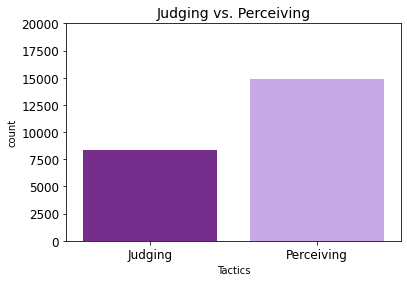

In [786]:
# Countplot of Judging - Perceiving
JPcolors = sns.xkcd_palette(['purple', 'lavender'])
sns.set_palette(JPcolors)
sns.countplot(x='Tactics', data=df, order=['Judging', 'Perceiving'])
plt.title('Judging vs. Perceiving', fontsize=14)
plt.ylim(0, 20000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

####Handling data imbalance

In [787]:
df['Tactics'].value_counts()

Perceiving    14892
Judging        8370
Name: Tactics, dtype: int64

In [788]:
from sklearn.utils import resample
#create two different dataframe of majority and minority class 
df_majority = df[df['Tactics']=='Perceiving'] 

df_minority = df[df['Tactics']=='Judging'] 

# upsample minority class
df = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 14892, # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
df = pd.concat([df, df_majority])

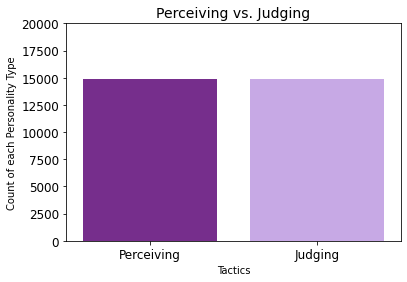

In [789]:
IEcolors = sns.xkcd_palette(['purple', 'lavender'])
sns.set_palette(IEcolors)
sns.countplot(x='Tactics', data=df, order=['Perceiving', 'Judging'])
plt.ylim(0, 20000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Tactics')
plt.ylabel('Count of each Personality Type')
plt.title('Perceiving vs. Judging', fontsize=14)
plt.show()

###Distribution class-wise after resampling

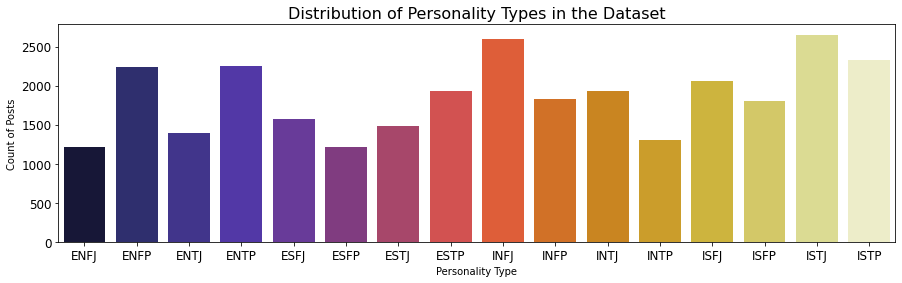

In [916]:
dim = (15.0, 4.0)
fig, ax = plt.subplots(figsize=dim)
cmrmap = sns.color_palette('CMRmap', 16)
sns.set_palette(cmrmap)
sns.countplot(x='type', data=df,
              order=['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ',
                     'ESTP', 'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP',
                     'ISTJ', 'ISTP'])
plt.title('Distribution of Personality Types in the Dataset', fontsize=16)
plt.xlabel('Personality Type')
plt.ylabel('Count of Posts')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

##Splitting data into test and train

In [791]:
data_X = df['posts']
data_y = df['type']
Xtrain, Xtest, ytrain, ytest = train_test_split(data_X, data_y, test_size =0.3, random_state = 2001)

In [792]:
train_data = pd.concat([ytrain, Xtrain], axis=1)
train_data

,type,posts
5245,INFP,"'damn. I don't feel too good. Actually, let me..."
5282,ESFJ,'I know this isn't the first post about the En...
4907,ESTJ,"'Asking if what they said/believe is factual, ..."
8147,ISFJ,"'So, I'm a 17 year old high school student who..."
6567,ENFP,'Personally I think Gemini and other air signs...
...,...,...
7301,ISFJ,"'Dear PerC, ...Hi, I'm back after over 2 year..."
989,ENTP,"'So, I've graduated with a Bachelors degree in..."
4113,ISFP,'If anyone ever grew up watching Homeward Boun...
6204,ESFP,'TBH why are you not a rapper?????|||A poem fo...


In [793]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20848 entries, 5245 to 751
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    20848 non-null  object
 1   posts   20848 non-null  object
dtypes: object(2)
memory usage: 488.6+ KB


In [794]:
test_data = pd.concat([ytest, Xtest], axis=1)
test_data

,type,posts
8446,ESFJ,'54586 Adelaide Labille-Guiard is my favorite...
7566,ISFP,They live in Stonypoint?|||I can't remember ha...
8234,ENTP,"'doctors tend to be scummy, but not my issue, ..."
4441,INFP,Numerically I lean towards being a late 2000s ...
3122,ESFP,'Good job! William I am!!!|||Yes to both. Sel...
...,...,...
993,INTJ,'Likewise. We need to write our own book then....
6382,ENFP,"'I have two INFP friends, one of whom has a cr..."
4107,ISTP,"'He's actually way too cute. And rich, which m..."
5908,INFJ,"'I also have long, natural hair and have never..."


In [795]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8936 entries, 8446 to 1450
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8936 non-null   object
 1   posts   8936 non-null   object
dtypes: object(2)
memory usage: 209.4+ KB


##Data pre-processing

###Removing delimeters

In [796]:
def remove_delimiters (post):
    new = post.replace('|||',' ')
    return ' '.join(new.split())

train_data['posts'] = train_data['posts'].apply(remove_delimiters)
test_data['posts'] = test_data['posts'].apply(remove_delimiters)

###Removing URLs

In [797]:
## Remove urls
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'

train_data['posts'] = train_data['posts'].replace(to_replace = pattern_url, value = subs_url, regex = True)
test_data['posts'] = test_data['posts'].replace(to_replace = pattern_url, value = subs_url, regex = True)

###Converting to lowercase

In [798]:
train_data['posts'] = train_data['posts'].str.lower()
test_data['posts'] = test_data['posts'].str.lower()

###Removing pucnctuation and numbers

In [799]:
#Remove punctuation & numbers
def remove_punctuation(post):
    punc_numbers = string.punctuation + '0123456789'
    return ''.join([l for l in post if l not in punc_numbers])

train_data['posts'] = train_data['posts'].apply(remove_punctuation)
test_data['posts'] = test_data['posts'].apply(remove_punctuation)

###Lemmatization

In [800]:
# Lematise posts
lemmatizer = WordNetLemmatizer()
train_data['lemma'] = [' '.join([lemmatizer.lemmatize(word) for word in text.split(' ')])for text in train_data['posts']]
test_data['lemma'] = [' '.join([lemmatizer.lemmatize(word) for word in text.split(' ')])for text in test_data['posts']]

###Removing stopwords

In [801]:
#Check for stopwords train
stop = stopwords.words('english')

train_data['stopwords'] = train_data['lemma'].apply(lambda x: len([x for x in x.split() if x in stop]))
train_data[['lemma','stopwords']].head()

test_data['stopwords'] = test_data['lemma'].apply(lambda x: len([x for x in x.split() if x in stop]))
test_data[['lemma','stopwords']].head()

,lemma,stopwords
8446,adelaide labilleguiard is my favorite painter...,791
7566,they live in stonypoint i cant remember haha l...,376
8234,doctor tend to be scummy but not my issue i se...,224
4441,numerically i lean towards being a late s kid ...,516
3122,good job william i am yes to both selfinterest...,647


##Logistic Regression Model

In [802]:
#Create binary classes for each of the personality characteristics
train_data['E'] = train_data['type'].apply(lambda x: x[0] == 'E').astype('int')
train_data['N'] = train_data['type'].apply(lambda x: x[1] == 'N').astype('int')
train_data['T'] = train_data['type'].apply(lambda x: x[2] == 'T').astype('int')
train_data['J'] = train_data['type'].apply(lambda x: x[3] == 'J').astype('int')

###Helper Functions

####Calculate log loss

In [803]:
def scoring_function_log_loss(y_test, y_pred_test):
    return log_loss(y_test, y_pred_test)

####Logistic Regression

In [804]:
def tune_LogReg_model(X_train, y_train): 
    C_list = [0.001, 0.01, 0.1, 0.5, 0.75, 1, 5, 10, 25, 100]
    penalty_list = ['l1','l2']

    score = make_scorer(scoring_function_log_loss, greater_is_better = False)
    
    logreg = LogisticRegression(max_iter=10000)
    
    parameters = {'C':C_list,
                  'penalty': penalty_list}
    tune = GridSearchCV(logreg, parameters, scoring = score)
    tune.fit(X_train,y_train)
    
    return tune

##COMPARING MODELS
- Logistic Regression
- Multinomial Naive Bayes
- AdaBoost Classifier
- LGBM Classifier

In [805]:
classes = ['E','N','T','J']

In [806]:
datasets = dict()
for i,column in enumerate(classes):
  df_c1 = train_data.drop(columns=train_data.columns.difference([column,'lemma']))
  temp1 = df_c1[df_c1[column] == 1]
  df_c1.drop(df_c1[df_c1[column] == 1].index,axis=0,inplace=True)
  df_c1 = pd.concat([temp1,df_c1],axis=0).reset_index(drop=True)
  datasets[column] = df_c1

In [807]:
def prep_train(X,vectorizer):
  X_tf = X.to_numpy()
  X_tfidf = vectorizer.transform(X_tf)
  return  X_tfidf

def train(classes,X,y):
  models_ = dict()
  for i,class_ in tqdm(enumerate(classes)):
    model = LogisticRegression(C=5, random_state=2020, max_iter=5000)
    model.fit(X[i],y[i])
    y_pred = model.predict(X[i])
    print()
    print(metrics.classification_report(y_pred, y[i]))
    models_[class_] = model
  return models_

In [808]:
vect = TfidfVectorizer(lowercase=True, 
                            stop_words='english', 
                            max_features=250,
                            min_df=4,
                            max_df=0.5
                           )

temp = train_data['lemma']
vect.fit(temp)
X_count = vect.transform(temp)

In [809]:
print(datasets)

{'E':                                                    lemma  E
0      i know this isnt the first post about the enne...  1
1      asking if what they saidbelieve is factual and...  1
2      personally i think gemini and other air sign f...  1
3      a the most introverted extrovert i am beginnin...  1
4      cheer for the tag  what is your favorite food ...  1
...                                                  ... ..
20843  some good reply thanks guy so what got me thin...  0
20844  i have found myself so completely out of my co...  0
20845  dear perc hi im back after over  year away i r...  0
20846  if anyone ever grew up watching homeward bound...  0
20847  for getting routine done these article have so...  0

[20848 rows x 2 columns], 'N':                                                    lemma  N
0      damn i dont feel too good actually let me refo...  1
1      personally i think gemini and other air sign f...  1
2      a the most introverted extrovert i am beginnin...  1
3 

In [810]:
X_tfidfs = list()
y_tfidfs = list()
for i in classes:
  X = prep_train(datasets[i]['lemma'], vect)
  y = np.array(datasets[i].drop(columns=['lemma'],axis=1))
  X_tfidfs.append(X)
  y_tfidfs.append(y)

###Results of various models

Mind label

In [811]:
list_of_models = [LogisticRegression(), MultinomialNB(), AdaBoostClassifier(), lgb.LGBMClassifier()]
for i in tqdm(list_of_models):
    model = i
    print(f"Training Model {model}")
    model.fit(X_tfidfs[0],y_tfidfs[0])
    y_pred = model.predict(X_tfidfs[0])
    print()
    print(metrics.classification_report(y_pred, y_tfidfs[0]))
    print(log_loss(y_pred, y_tfidfs[0]))
    print()

  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Model LogisticRegression()


 25%|██▌       | 1/4 [00:00<00:01,  2.79it/s]


              precision    recall  f1-score   support

           0       0.87      0.84      0.86     11958
           1       0.80      0.83      0.81      8890

    accuracy                           0.84     20848
   macro avg       0.83      0.84      0.83     20848
weighted avg       0.84      0.84      0.84     20848

5.627865553023509

Training Model MultinomialNB()

              precision    recall  f1-score   support

           0       0.91      0.73      0.81     14449
           1       0.57      0.83      0.68      6399

    accuracy                           0.76     20848
   macro avg       0.74      0.78      0.74     20848
weighted avg       0.80      0.76      0.77     20848

8.336640925969473

Training Model AdaBoostClassifier()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 75%|███████▌  | 3/4 [00:12<00:04,  4.48s/it]


              precision    recall  f1-score   support

           0       0.87      0.82      0.85     12308
           1       0.76      0.83      0.79      8540

    accuracy                           0.82     20848
   macro avg       0.82      0.83      0.82     20848
weighted avg       0.83      0.82      0.83     20848

6.055304510597653

Training Model LGBMClassifier()


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
100%|██████████| 4/4 [00:20<00:00,  5.20s/it]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     11579
           1       0.98      0.98      0.98      9269

    accuracy                           0.98     20848
   macro avg       0.98      0.98      0.98     20848
weighted avg       0.98      0.98      0.98     20848

0.5202086205282432



Energy label

In [812]:
for i in tqdm(list_of_models):
    model = i
    print(f"Training Model {model}")
    model.fit(X_tfidfs[1],y_tfidfs[1])
    y_pred = model.predict(X_tfidfs[1])
    print()
    print(metrics.classification_report(y_pred, y_tfidfs[1]))
    print(log_loss(y_pred, y_tfidfs[1]))
    print()

  0%|          | 0/4 [00:00<?, ?it/s]

Training Model LogisticRegression()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 25%|██▌       | 1/4 [00:00<00:01,  2.87it/s]


              precision    recall  f1-score   support

           0       0.87      0.85      0.86     10853
           1       0.84      0.86      0.85      9995

    accuracy                           0.85     20848
   macro avg       0.85      0.85      0.85     20848
weighted avg       0.85      0.85      0.85     20848

5.061267057509868

Training Model MultinomialNB()

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     10692
           1       0.81      0.82      0.82     10156

    accuracy                           0.82     20848
   macro avg       0.82      0.82      0.82     20848
weighted avg       0.82      0.82      0.82     20848

6.146411725546694

Training Model AdaBoostClassifier()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 75%|███████▌  | 3/4 [00:12<00:04,  4.69s/it]


              precision    recall  f1-score   support

           0       0.85      0.83      0.84     10769
           1       0.82      0.84      0.83     10079

    accuracy                           0.83     20848
   macro avg       0.83      0.83      0.83     20848
weighted avg       0.83      0.83      0.83     20848

5.723951098873943

Training Model LGBMClassifier()


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
100%|██████████| 4/4 [00:21<00:00,  5.38s/it]


              precision    recall  f1-score   support

           0       1.00      0.99      0.99     10694
           1       0.98      1.00      0.99     10154

    accuracy                           0.99     20848
   macro avg       0.99      0.99      0.99     20848
weighted avg       0.99      0.99      0.99     20848

0.3147780243779816



Nature label

In [813]:
for i in tqdm(list_of_models):
    model = i
    print(f"Training Model {model}")
    model.fit(X_tfidfs[2],y_tfidfs[2])
    y_pred = model.predict(X_tfidfs[2])
    print()
    print(metrics.classification_report(y_pred, y_tfidfs[2]))
    print(log_loss(y_pred, y_tfidfs[2]))
    print()

  0%|          | 0/4 [00:00<?, ?it/s]

Training Model LogisticRegression()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 25%|██▌       | 1/4 [00:00<00:01,  2.88it/s]


              precision    recall  f1-score   support

           0       0.85      0.85      0.85     10271
           1       0.85      0.86      0.85     10577

    accuracy                           0.85     20848
   macro avg       0.85      0.85      0.85     20848
weighted avg       0.85      0.85      0.85     20848

5.147411973393944

Training Model MultinomialNB()

              precision    recall  f1-score   support

           0       0.78      0.83      0.80      9512
           1       0.85      0.80      0.82     11336

    accuracy                           0.81     20848
   macro avg       0.81      0.82      0.81     20848
weighted avg       0.82      0.81      0.82     20848

6.394903158475268

Training Model AdaBoostClassifier()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 75%|███████▌  | 3/4 [00:12<00:04,  4.77s/it]


              precision    recall  f1-score   support

           0       0.82      0.83      0.83     10035
           1       0.84      0.83      0.84     10813

    accuracy                           0.83     20848
   macro avg       0.83      0.83      0.83     20848
weighted avg       0.83      0.83      0.83     20848

5.84322738248959

Training Model LGBMClassifier()


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
100%|██████████| 4/4 [00:21<00:00,  5.46s/it]


              precision    recall  f1-score   support

           0       0.98      0.98      0.98     10199
           1       0.98      0.98      0.98     10649

    accuracy                           0.98     20848
   macro avg       0.98      0.98      0.98     20848
weighted avg       0.98      0.98      0.98     20848

0.6113273032263079



Tactics label

In [814]:
for i in tqdm(list_of_models):
    model = i
    print(f"Training Model {model}")
    model.fit(X_tfidfs[3],y_tfidfs[3])
    y_pred = model.predict(X_tfidfs[3])
    print()
    print(metrics.classification_report(y_pred, y_tfidfs[3]))
    print(log_loss(y_pred, y_tfidfs[3]))
    print()

  0%|          | 0/4 [00:00<?, ?it/s]

Training Model LogisticRegression()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 25%|██▌       | 1/4 [00:00<00:01,  2.06it/s]


              precision    recall  f1-score   support

           0       0.83      0.81      0.82     10577
           1       0.81      0.82      0.82     10271

    accuracy                           0.82     20848
   macro avg       0.82      0.82      0.82     20848
weighted avg       0.82      0.82      0.82     20848

6.290547369874396

Training Model MultinomialNB()

              precision    recall  f1-score   support

           0       0.80      0.79      0.79     10502
           1       0.79      0.80      0.79     10346

    accuracy                           0.79     20848
   macro avg       0.79      0.79      0.79     20848
weighted avg       0.79      0.79      0.79     20848

7.17688799145374

Training Model AdaBoostClassifier()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 75%|███████▌  | 3/4 [00:13<00:04,  4.81s/it]


              precision    recall  f1-score   support

           0       0.80      0.82      0.81     10173
           1       0.83      0.81      0.82     10675

    accuracy                           0.81     20848
   macro avg       0.81      0.81      0.81     20848
weighted avg       0.81      0.81      0.81     20848

6.406509611570141

Training Model LGBMClassifier()


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
100%|██████████| 4/4 [00:21<00:00,  5.41s/it]


              precision    recall  f1-score   support

           0       0.98      0.98      0.98     10372
           1       0.98      0.98      0.98     10476

    accuracy                           0.98     20848
   macro avg       0.98      0.98      0.98     20848
weighted avg       0.98      0.98      0.98     20848

0.8349838067342249



###Splitting data

In [815]:
X_temp = train_data['lemma']
y_temp = train_data.drop(columns=['lemma'],axis=1)

X_train, X_valid, y_train , y_valid = train_test_split(X_temp, y_temp, test_size=0.2)

print("train_message : ", X_train.shape)
print("train_target : ", y_train.shape)
print("val_message : ", X_valid.shape)
print("val_target : ", y_valid.shape)

train_message :  (16678,)
train_target :  (16678, 7)
val_message :  (4170,)
val_target :  (4170, 7)


In [816]:
models_ = train(classes,X_tfidfs,y_tfidfs)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
1it [00:00,  1.78it/s]


              precision    recall  f1-score   support

           0       0.87      0.84      0.86     11860
           1       0.80      0.83      0.81      8988

    accuracy                           0.84     20848
   macro avg       0.83      0.84      0.83     20848
weighted avg       0.84      0.84      0.84     20848



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
2it [00:01,  1.92it/s]


              precision    recall  f1-score   support

           0       0.86      0.84      0.85     10828
           1       0.84      0.86      0.85     10020

    accuracy                           0.85     20848
   macro avg       0.85      0.85      0.85     20848
weighted avg       0.85      0.85      0.85     20848



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
3it [00:01,  2.02it/s]


              precision    recall  f1-score   support

           0       0.85      0.84      0.85     10286
           1       0.85      0.86      0.85     10562

    accuracy                           0.85     20848
   macro avg       0.85      0.85      0.85     20848
weighted avg       0.85      0.85      0.85     20848



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
4it [00:02,  1.91it/s]


              precision    recall  f1-score   support

           0       0.82      0.81      0.82     10533
           1       0.81      0.82      0.82     10315

    accuracy                           0.82     20848
   macro avg       0.82      0.82      0.82     20848
weighted avg       0.82      0.82      0.82     20848



###Results on validation set class-wise

In [817]:
def validation(X,y,vectorizer,target):
  print(f"Validating Model {models_[target]}")
  y_pred = models_[target].predict_proba(X)
  #print(Counter(y_pred))
  #print(Counter(y))
  #print(metrics.classification_report(y_pred, y))
  print("Neg Log Loss: ", metrics.log_loss(y, y_pred))
  print()
  #print(' score: %.4f' % np.mean(cross_val_score(models_[target], X, y, scoring='accuracy', cv=5)))

In [818]:
X_valid_for_tf = X_valid.to_numpy()
X_valid_tfidf = vect.transform(X_valid_for_tf)
label_1 = [0,1,2,3,4,5,6,7,8,9]
label_2 = [0,1]
for i,class_ in enumerate(classes):
  print(f"Class: {class_}")
  if i not in [0,5]:
    validation(X_valid_tfidf,y_valid[class_],vect,class_)
  else:
    validation(X_valid_tfidf,y_valid[class_],vect,class_)

Class: E
Validating Model LogisticRegression(C=5, max_iter=5000, random_state=2020)
Neg Log Loss:  0.39103543202148316

Class: N
Validating Model LogisticRegression(C=5, max_iter=5000, random_state=2020)
Neg Log Loss:  0.3680812740744452

Class: T
Validating Model LogisticRegression(C=5, max_iter=5000, random_state=2020)
Neg Log Loss:  0.3625140357882903

Class: J
Validating Model LogisticRegression(C=5, max_iter=5000, random_state=2020)
Neg Log Loss:  0.4137959645220212



##Mind model

###Vectorization

In [819]:
mind_df = train_data[['lemma','E']]

In [820]:
vect_mind = TfidfVectorizer(lowercase=True, 
                            stop_words='english', 
                            max_features=250,
                            min_df=4,
                            max_df=0.5
                           )

vect_mind.fit(mind_df['lemma'])
X_count_mind = vect_mind.transform(mind_df['lemma'])

In [821]:
X_count_mind.shape

(20848, 250)

In [822]:
vect_mind.get_feature_names()

['able',
 'absolutely',
 'act',
 'advice',
 'ago',
 'agree',
 'answer',
 'arent',
 'ask',
 'away',
 'awesome',
 'bad',
 'based',
 'believe',
 'big',
 'bit',
 'book',
 'came',
 'care',
 'case',
 'cause',
 'certain',
 'change',
 'character',
 'child',
 'class',
 'close',
 'college',
 'completely',
 'consider',
 'conversation',
 'cool',
 'couple',
 'course',
 'crazy',
 'dad',
 'deal',
 'definitely',
 'depends',
 'description',
 'difference',
 'dream',
 'easy',
 'emotion',
 'emotional',
 'end',
 'enfj',
 'enfp',
 'enfps',
 'enjoy',
 'enneagram',
 'entj',
 'entp',
 'entps',
 'esfj',
 'esfp',
 'especially',
 'estj',
 'estp',
 'exactly',
 'example',
 'experience',
 'eye',
 'face',
 'fact',
 'family',
 'far',
 'favorite',
 'fe',
 'felt',
 'female',
 'fi',
 'figure',
 'fit',
 'forum',
 'fun',
 'function',
 'funny',
 'game',
 'general',
 'generally',
 'getting',
 'girl',
 'god',
 'great',
 'group',
 'guess',
 'haha',
 'hand',
 'happy',
 'hate',
 'havent',
 'having',
 'head',
 'hear',
 'hell',
 '

###Splitting data

In [823]:
X = X_count_mind
y = mind_df['E']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size =0.3,
                                                   random_state = 2001)

###Finding best model

In [824]:
best_mind_model = tune_LogReg_model(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solve

In [825]:
best_mind_model.best_params_

{'C': 1, 'penalty': 'l2'}

###Training

In [826]:
mind_model = LogisticRegression(C=best_mind_model.best_params_['C'], penalty = best_mind_model.best_params_['penalty'])
mind_model.fit(X_train, y_train)

LogisticRegression(C=1)

###Results

####Accuracy score

On train data

In [827]:
y_pred_train = mind_model.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print(acc_train)

0.8419105050366614


On test data

In [828]:
y_pred_test = mind_model.predict(X_test)
acc_test = accuracy_score(y_test, y_pred_test)
print(acc_test)

0.8236610711430855


####Classification reports

On train data

In [829]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      8091
           1       0.84      0.80      0.82      6502

    accuracy                           0.84     14593
   macro avg       0.84      0.84      0.84     14593
weighted avg       0.84      0.84      0.84     14593



On test data

In [830]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84      3468
           1       0.81      0.78      0.80      2787

    accuracy                           0.82      6255
   macro avg       0.82      0.82      0.82      6255
weighted avg       0.82      0.82      0.82      6255



####Log losses

Train data

In [831]:
log_loss(y_train, y_pred_train)

5.460273332039375

Test data

In [832]:
log_loss(y_test, y_pred_test)

6.090594622334796

In [833]:
mind_log_loss = cross_val_score(mind_model, X, y, scoring= make_scorer(scoring_function_log_loss, greater_is_better = False),cv=4,)
print('Log Loss %2f' %(-1 * mind_log_loss.mean()))

mind_acc = cross_val_score(mind_model, X, y, scoring='accuracy',cv=4,)
print('Accuracy %2f' %(mind_acc.mean()))

Log Loss 5.786896
Accuracy 0.832454


##Energy model

In [834]:
energy_df = train_data[['lemma','N']]

###Vectorization

In [835]:
vect_energy = TfidfVectorizer(lowercase=True, 
                            stop_words='english', 
                            max_features=195,
                            min_df=4,
                            max_df=0.5
                           )
vect_energy.fit(energy_df['lemma'])
X_count_energy = vect_energy.transform(energy_df['lemma'])

In [836]:
X_count_energy.shape

(20848, 195)

In [837]:
vect_energy.get_feature_names()

['able',
 'advice',
 'ago',
 'agree',
 'answer',
 'arent',
 'ask',
 'away',
 'awesome',
 'bad',
 'based',
 'believe',
 'big',
 'bit',
 'book',
 'care',
 'case',
 'certain',
 'change',
 'character',
 'child',
 'class',
 'close',
 'completely',
 'conversation',
 'cool',
 'course',
 'crazy',
 'definitely',
 'depends',
 'description',
 'emotion',
 'emotional',
 'end',
 'enfj',
 'enfp',
 'enjoy',
 'entj',
 'entp',
 'esfj',
 'esfp',
 'especially',
 'estj',
 'estp',
 'exactly',
 'example',
 'experience',
 'eye',
 'fact',
 'family',
 'far',
 'favorite',
 'fe',
 'felt',
 'female',
 'fi',
 'fit',
 'forum',
 'fun',
 'function',
 'funny',
 'game',
 'general',
 'getting',
 'girl',
 'great',
 'group',
 'guess',
 'haha',
 'happy',
 'hate',
 'havent',
 'having',
 'head',
 'hear',
 'hello',
 'hey',
 'hi',
 'high',
 'home',
 'hope',
 'hour',
 'infj',
 'infjs',
 'infp',
 'interested',
 'interesting',
 'intj',
 'intjs',
 'intp',
 'isfj',
 'isfp',
 'isnt',
 'issue',
 'istj',
 'istp',
 'job',
 'kid',
 'laug

###Splitting data

In [838]:
X = X_count_energy
y = energy_df['N']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size =0.3,
                                                   random_state = 2001)

###Finding best model

In [839]:
best_energy_model = tune_LogReg_model(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solve

In [840]:
best_energy_model.best_params_

{'C': 0.1, 'penalty': 'l2'}

###Training

In [841]:
energy_model = LogisticRegression(C=best_energy_model.best_params_['C'], penalty = best_energy_model.best_params_['penalty'])
energy_model.fit(X_train, y_train)

LogisticRegression(C=0.1)

###Results

####Accuracy score

train data

In [842]:
y_pred_train = energy_model.predict(X_train)

accuracy_score(y_train, y_pred_train)

0.8382786267388473

test data

In [843]:
y_pred_test = energy_model.predict(X_test)

accuracy_score(y_test, y_pred_test)

0.8367705835331735

####Classification report

Train data

In [844]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      7433
           1       0.84      0.83      0.83      7160

    accuracy                           0.84     14593
   macro avg       0.84      0.84      0.84     14593
weighted avg       0.84      0.84      0.84     14593



Test data

In [845]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      3139
           1       0.84      0.83      0.84      3116

    accuracy                           0.84      6255
   macro avg       0.84      0.84      0.84      6255
weighted avg       0.84      0.84      0.84      6255



####Log losses

Train data

In [846]:
log_loss(y_train, y_pred_train)

5.5857216903048394

Test data

In [847]:
log_loss(y_train, y_pred_train)

5.5857216903048394

In [848]:
energy_log_loss = cross_val_score(energy_model, X, y, scoring=make_scorer(scoring_function_log_loss, greater_is_better = False),cv=4)
print('Log Loss %2f' %(-1 * energy_log_loss.mean()))

energy_acc = cross_val_score(energy_model, X, y, scoring='accuracy',cv=4,)
print('Accuracy %2f' %(energy_acc.mean()))

Log Loss 5.664304
Accuracy 0.836003


##Nature model

In [849]:
nature_df = train_data[['lemma','T']]

###Vectorizer

In [850]:
vect_nature = TfidfVectorizer(lowercase=True, 
                            stop_words='english', 
                            max_features=3900,
                            min_df=4,
                            max_df=0.5
                            #ngram_range=(3,3)
                           )
vect_nature.fit(nature_df['lemma'])
X_count_nature = vect_nature.transform(nature_df['lemma'])

In [851]:
X_count_nature.shape

(20848, 3900)

In [852]:
vect_nature.get_feature_names()

['ability',
 'able',
 'abroad',
 'absolute',
 'absolutely',
 'abstract',
 'absurd',
 'abt',
 'abuse',
 'abusive',
 'academic',
 'accent',
 'accept',
 'acceptable',
 'acceptance',
 'accepted',
 'accepting',
 'access',
 'accident',
 'accidentally',
 'accomplish',
 'accomplished',
 'accomplishment',
 'according',
 'accordingly',
 'account',
 'accuracy',
 'accurate',
 'accurately',
 'accused',
 'ace',
 'achieve',
 'achievement',
 'acknowledge',
 'acquaintance',
 'act',
 'acted',
 'acting',
 'action',
 'active',
 'actively',
 'activity',
 'actor',
 'actual',
 'ad',
 'adam',
 'adapt',
 'add',
 'added',
 'addicted',
 'addiction',
 'adding',
 'addition',
 'address',
 'adhd',
 'admire',
 'admit',
 'adorable',
 'adore',
 'adult',
 'advance',
 'advanced',
 'advantage',
 'adventure',
 'adventurous',
 'advice',
 'advise',
 'advocate',
 'aesthetic',
 'affect',
 'affected',
 'affection',
 'affectionate',
 'affirmation',
 'afford',
 'afraid',
 'afternoon',
 'age',
 'agenda',
 'agent',
 'aggressive',
 

###Splitting the data

In [853]:
X = X_count_nature
y = nature_df['T']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size =0.3,
                                                   random_state = 2001)

###Finding best model

In [854]:
best_nature_model = tune_LogReg_model(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solve

In [855]:
best_nature_model.best_params_

{'C': 100, 'penalty': 'l2'}

###Training

In [856]:
nature_model = LogisticRegression(C=5)
nature_model.fit(X_train, y_train)

LogisticRegression(C=5)

###Results

####Accuracy score

Train data

In [857]:
y_pred_train = nature_model.predict(X_train)

accuracy_score(y_train, y_pred_train)

0.9773864181456863

Test data

In [858]:
y_pred_test = nature_model.predict(X_test)

accuracy_score(y_test, y_pred_test)

0.943884892086331

####Classificaation reports

Train data

In [859]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      7161
           1       0.98      0.98      0.98      7432

    accuracy                           0.98     14593
   macro avg       0.98      0.98      0.98     14593
weighted avg       0.98      0.98      0.98     14593



Test data

In [860]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3049
           1       0.95      0.94      0.95      3206

    accuracy                           0.94      6255
   macro avg       0.94      0.94      0.94      6255
weighted avg       0.94      0.94      0.94      6255



####Log losses

Train data

In [861]:
log_loss(y_train, y_pred_train)

0.7810545428283389

Test data

In [862]:
log_loss(y_test, y_pred_test)

1.9381692797712353

##Tactics model

In [863]:
tactics_df = train_data[['lemma','J']]

###Vectorizer

In [864]:
vect_tactics = TfidfVectorizer(lowercase=True, 
                            stop_words='english', 
                            max_features=260,
                            min_df=4,
                            max_df=0.5
                           )
vect_tactics.fit(tactics_df['lemma'])
X_count_tactics = vect_tactics.transform(tactics_df['lemma'])

In [865]:
X_count_tactics.shape

(20848, 260)

In [866]:
vect_tactics.get_feature_names()

['able',
 'absolutely',
 'act',
 'advice',
 'age',
 'ago',
 'agree',
 'answer',
 'arent',
 'ask',
 'asking',
 'away',
 'awesome',
 'bad',
 'based',
 'believe',
 'big',
 'bit',
 'book',
 'came',
 'care',
 'case',
 'cause',
 'certain',
 'change',
 'character',
 'child',
 'class',
 'close',
 'college',
 'completely',
 'consider',
 'conversation',
 'cool',
 'couple',
 'course',
 'crazy',
 'dad',
 'deal',
 'definitely',
 'depends',
 'description',
 'difference',
 'dream',
 'easy',
 'emotion',
 'emotional',
 'end',
 'enfj',
 'enfp',
 'enfps',
 'enjoy',
 'enneagram',
 'entj',
 'entp',
 'entps',
 'esfj',
 'esfp',
 'especially',
 'estj',
 'estp',
 'exactly',
 'example',
 'experience',
 'eye',
 'face',
 'fact',
 'family',
 'far',
 'favorite',
 'fe',
 'felt',
 'female',
 'fi',
 'figure',
 'fit',
 'forum',
 'fun',
 'function',
 'funny',
 'game',
 'general',
 'generally',
 'getting',
 'girl',
 'god',
 'great',
 'group',
 'guess',
 'haha',
 'hand',
 'happy',
 'hate',
 'havent',
 'having',
 'head',
 

###Splitting the data

In [867]:
X = X_count_tactics
y = tactics_df['J']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size =0.3,
                                                   random_state = 2001)

###Finding best model

In [868]:
best_tactics_model = tune_LogReg_model(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solve

In [869]:
best_tactics_model.best_params_

{'C': 100, 'penalty': 'l2'}

###Training

In [870]:
tactics_model = LogisticRegression(C=best_tactics_model.best_params_['C'], penalty = best_tactics_model.best_params_['penalty'])
tactics_model.fit(X_train, y_train)

LogisticRegression(C=100)

###Results

####Accuracy score

Train data

In [871]:
y_pred_train = tactics_model.predict(X_train)

accuracy_score(y_train, y_pred_train)

0.8271774138285479

Test data

In [872]:
y_pred_test = tactics_model.predict(X_test)

accuracy_score(y_test, y_pred_test)

0.8113509192645884

####Classification reports

Train data

In [873]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.82      0.83      0.83      7258
           1       0.83      0.82      0.83      7335

    accuracy                           0.83     14593
   macro avg       0.83      0.83      0.83     14593
weighted avg       0.83      0.83      0.83     14593



Test data

In [874]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.81      0.82      0.81      3120
           1       0.81      0.81      0.81      3135

    accuracy                           0.81      6255
   macro avg       0.81      0.81      0.81      6255
weighted avg       0.81      0.81      0.81      6255



####Log loss

Train data

In [875]:
log_loss(y_train, y_pred_train)

5.9691482198037535

Test data

In [876]:
log_loss(y_test, y_pred_test)

6.515782176452731

In [877]:
tactics_log_loss = cross_val_score(tactics_model, X, y, scoring=make_scorer(scoring_function_log_loss, greater_is_better = False), cv=4,)
print('Log Loss %2f' %(-1 * tactics_log_loss.mean()))

tactics_acc = cross_val_score(tactics_model, X, y, scoring='accuracy',cv=4,)
print('Accuracy %2f' %(tactics_acc.mean()))

Log Loss 6.428049
Accuracy 0.813891


##Prediction on Test Data

###Predicting Mind

In [878]:
pred_count1 = vect_mind.transform(test_data['lemma'])
pred_count1.shape

(8936, 250)

In [879]:
test_data['E'] = test_data['type'].apply(lambda x: x[0] == 'E').astype('int')
mind_df_test = test_data[['lemma','E']]

In [880]:
X1 = X_count_mind
y1 = mind_df['E']

final_mind_model = mind_model
final_mind_model.fit(X1, y1)

final_mind_predictions = final_mind_model.predict(pred_count1)

test_data['E_pred'] = final_mind_predictions

Accuracy

In [881]:
y1_pred = mind_df_test['E']
print(accuracy_score(y1_pred, final_mind_predictions))

0.8341539838854073


In [882]:
print(classification_report(y1_pred, final_mind_predictions))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85      4942
           1       0.83      0.79      0.81      3994

    accuracy                           0.83      8936
   macro avg       0.83      0.83      0.83      8936
weighted avg       0.83      0.83      0.83      8936



In [883]:
print(log_loss(y1_pred, final_mind_predictions))

5.728176807831481


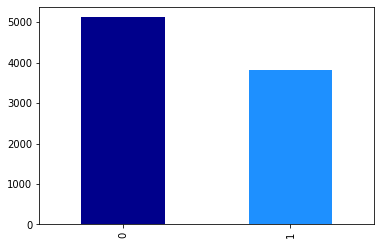

In [884]:
test_data['E_pred'].value_counts().plot(kind = 'bar',color = ['darkblue','dodgerblue'])
plt.show()

###Predicting Energy

In [885]:
pred_count2 = vect_energy.transform(test_data['lemma'])
pred_count2.shape

(8936, 195)

In [886]:
test_data['N'] = test_data['type'].apply(lambda x: x[1] == 'N').astype('int')
energy_df_test = test_data[['lemma','N']]

In [887]:
X2 = X_count_energy
y2 = energy_df['N']

final_energy_model = energy_model
final_energy_model.fit(X2, y2)

final_energy_predictions = final_energy_model.predict(pred_count2)

test_data['N_pred'] = final_energy_predictions

Accuracy

In [888]:
y2_pred = energy_df_test['N']
print(accuracy_score(y2_pred, final_energy_predictions))

0.8362802148612355


In [889]:
print(classification_report(y2_pred, final_energy_predictions))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      4464
           1       0.84      0.83      0.84      4472

    accuracy                           0.84      8936
   macro avg       0.84      0.84      0.84      8936
weighted avg       0.84      0.84      0.84      8936



In [890]:
print(log_loss(y2_pred, final_energy_predictions))

5.654743060292464


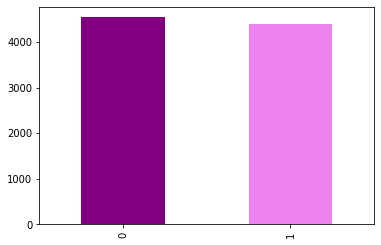

In [891]:
test_data['N_pred'].value_counts().plot(kind = 'bar', color = ['purple','violet'])
plt.show()

###Predicting Nature

In [892]:
pred_count3 = vect_nature.transform(test_data['lemma'])
pred_count3.shape

(8936, 3900)

In [893]:
test_data['T'] = test_data['type'].apply(lambda x: x[2] == 'T').astype('int')
nature_df_test = test_data[['lemma','T']]

In [894]:
X3 = X_count_nature
y3 = nature_df['T']

final_nature_model = nature_model
final_nature_model.fit(X3, y3)

final_nature_predictions = final_nature_model.predict(pred_count3)

test_data['T_pred'] = final_nature_predictions

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy

In [895]:
y3_pred = nature_df_test['T']
print(accuracy_score(y3_pred, final_nature_predictions))

0.9485228290062668


In [896]:
print(classification_report(y3_pred, final_nature_predictions))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4300
           1       0.95      0.95      0.95      4636

    accuracy                           0.95      8936
   macro avg       0.95      0.95      0.95      8936
weighted avg       0.95      0.95      0.95      8936



In [897]:
print(log_loss(y3_pred, final_nature_predictions))

1.7779794368238122


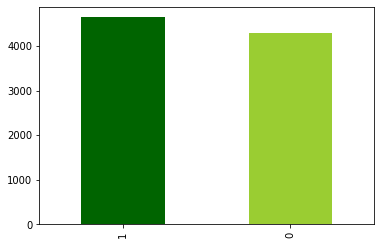

In [898]:
test_data['T_pred'].value_counts().plot(kind = 'bar', color = ['darkgreen','yellowgreen'])
plt.show()

###Predicting Tactics

In [899]:
pred_count4 = vect_tactics.transform(test_data['lemma'])
pred_count4.shape

(8936, 260)

In [900]:
test_data['J'] = test_data['type'].apply(lambda x: x[3] == 'J').astype('int')
nature_df_test = test_data[['lemma','J']]

In [901]:
X4 = X_count_tactics
y4 = tactics_df['J']

final_tactics_model = tactics_model
final_tactics_model.fit(X4, y4)

final_tactics_predictions = final_tactics_model.predict(pred_count4)

test_data['J_pred'] = final_tactics_predictions

Accuracy

In [902]:
y4_pred = nature_df_test['J']
print(accuracy_score(y4_pred, final_tactics_predictions))

0.8138988361683079


Classification report

In [903]:
print(classification_report(y4_pred, final_tactics_predictions))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82      4514
           1       0.81      0.81      0.81      4422

    accuracy                           0.81      8936
   macro avg       0.81      0.81      0.81      8936
weighted avg       0.81      0.81      0.81      8936



In [904]:
print(log_loss(y4_pred, final_tactics_predictions))

6.427781469044648


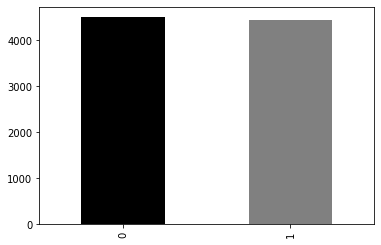

In [905]:
test_data['J_pred'].value_counts().plot(kind = 'bar', color = ['black','grey'])
plt.show()

In [906]:
test_data

,type,posts,lemma,stopwords,E,E_pred,N,N_pred,T,T_pred,J,J_pred
8446,ESFJ,adelaide labilleguiard is my favorite painter...,adelaide labilleguiard is my favorite painter...,791,1,0,0,0,0,0,1,1
7566,ISFP,they live in stonypoint i cant remember haha l...,they live in stonypoint i cant remember haha l...,376,0,0,0,0,0,0,0,0
8234,ENTP,doctors tend to be scummy but not my issue i s...,doctor tend to be scummy but not my issue i se...,224,1,0,1,0,1,1,0,1
4441,INFP,numerically i lean towards being a late s kid ...,numerically i lean towards being a late s kid ...,516,0,0,1,0,0,0,0,0
3122,ESFP,good job william i am yes to both selfinterest...,good job william i am yes to both selfinterest...,647,1,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
993,INTJ,likewise we need to write our own book then in...,likewise we need to write our own book then in...,792,0,1,1,1,1,1,1,0
6382,ENFP,i have two infp friends one of whom has a crus...,i have two infp friend one of whom ha a crush ...,618,1,1,1,1,0,0,0,0
4107,ISTP,hes actually way too cute and rich which makes...,he actually way too cute and rich which make m...,551,0,0,0,1,1,1,0,0
5908,INFJ,i also have long natural hair and have never d...,i also have long natural hair and have never d...,627,0,0,1,0,0,0,1,0


###Prediction for each of the 4 characteristics

In [907]:
pred_lemma = test_data['lemma']
pred_mind_df = test_data['E_pred']
pred_energy_df = test_data['N_pred']
pred_nature_df = test_data['T_pred']
pred_tactics_df = test_data['J_pred']

In [908]:
final_pred = pd.concat([pred_lemma, pred_mind_df, pred_energy_df, pred_nature_df, pred_tactics_df], axis=1) 
final_pred.head(10)

,lemma,E_pred,N_pred,T_pred,J_pred
8446,adelaide labilleguiard is my favorite painter...,0,0,0,1
7566,they live in stonypoint i cant remember haha l...,0,0,0,0
8234,doctor tend to be scummy but not my issue i se...,0,0,1,1
4441,numerically i lean towards being a late s kid ...,0,0,0,0
3122,good job william i am yes to both selfinterest...,1,1,0,0
7315,yeah im not a fan of kiersey at all granted i ...,1,0,0,0
6246,kindofblue honestly i dont need anyone to take...,1,1,0,0
1120,i dont have much useful advice but you trigge...,0,1,1,0
3126,highclasssavage crushkilldestroy urien poloniu...,1,0,0,0
2589,maker then survivor the air is so quiet john j...,0,0,0,1


In [909]:
final_pred.rename(columns={'E_pred':'mind',
                            'N_pred': 'energy',
                            'T_pred': 'nature',
                            'J_pred': 'tactics'
                             }, 
                 inplace=True)

final_pred.head()

,lemma,mind,energy,nature,tactics
8446,adelaide labilleguiard is my favorite painter...,0,0,0,1
7566,they live in stonypoint i cant remember haha l...,0,0,0,0
8234,doctor tend to be scummy but not my issue i se...,0,0,1,1
4441,numerically i lean towards being a late s kid ...,0,0,0,0
3122,good job william i am yes to both selfinterest...,1,1,0,0


####Create column for the predictions of each of the 4 chracteristics

In [910]:
final_pred['Mind Pred'] = final_pred['mind'].map(lambda x: 'E' if x == 1 else 'I')
final_pred['Energy Pred'] = final_pred['energy'].map(lambda x: 'N' if x == 1 else 'S')
final_pred['Nature Pred'] = final_pred['nature'].map(lambda x: 'T' if x == 1 else 'F')
final_pred['Tactics Pred'] = final_pred['tactics'].map(lambda x: 'J' if x == 1 else 'P')
final_pred.head()

,lemma,mind,energy,nature,tactics,Mind Pred,Energy Pred,Nature Pred,Tactics Pred
8446,adelaide labilleguiard is my favorite painter...,0,0,0,1,I,S,F,J
7566,they live in stonypoint i cant remember haha l...,0,0,0,0,I,S,F,P
8234,doctor tend to be scummy but not my issue i se...,0,0,1,1,I,S,T,J
4441,numerically i lean towards being a late s kid ...,0,0,0,0,I,S,F,P
3122,good job william i am yes to both selfinterest...,1,1,0,0,E,N,F,P


In [911]:
final_pred['Personality Pred'] = final_pred['Mind Pred'] + final_pred['Energy Pred'] + final_pred['Nature Pred']+ final_pred['Tactics Pred']

In [912]:
final_pred.head()

,lemma,mind,energy,nature,tactics,Mind Pred,Energy Pred,Nature Pred,Tactics Pred,Personality Pred
8446,adelaide labilleguiard is my favorite painter...,0,0,0,1,I,S,F,J,ISFJ
7566,they live in stonypoint i cant remember haha l...,0,0,0,0,I,S,F,P,ISFP
8234,doctor tend to be scummy but not my issue i se...,0,0,1,1,I,S,T,J,ISTJ
4441,numerically i lean towards being a late s kid ...,0,0,0,0,I,S,F,P,ISFP
3122,good job william i am yes to both selfinterest...,1,1,0,0,E,N,F,P,ENFP


###Plots for final predicted data

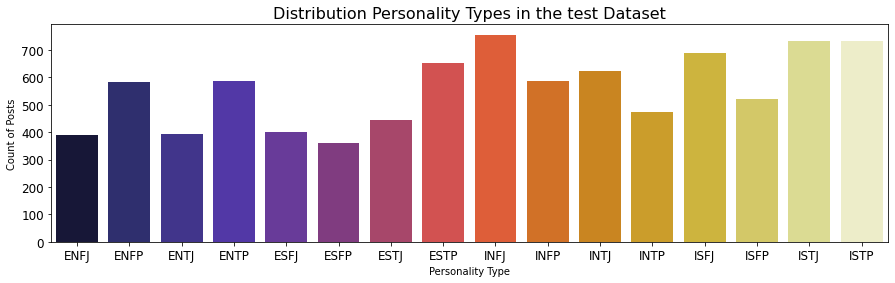

In [915]:
dims1 = (15.0, 4.0)
fig, ax = plt.subplots(figsize=dims1)
cmrmap = sns.color_palette('CMRmap', 16)
sns.set_palette(cmrmap)
sns.countplot(x='Personality Pred', data=final_pred,\
              order=['ENFJ','ENFP','ENTJ','ENTP','ESFJ','ESFP','ESTJ','ESTP',\
                    'INFJ','INFP','INTJ','INTP','ISFJ','ISFP','ISTJ','ISTP'])
plt.title('Distribution Personality Types in the test Dataset', fontsize=16)
plt.xlabel('Personality Type')
plt.ylabel('Count of Posts')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()